# Finite-Amplitude Surface Waves on Falling Liquid Films

This note describes a Python solver for the surface wave equation \eqref{eq:eta} derived by [Gjevik, 1970](https://doi.org/10.1063/1.1693186). The note is written using [jupyter](https://jupyter.org), and the solver is using [shenfun](https://github.com/spectralDNS/shenfun) for its simple interface to the Fourier base functions, and its ability to do dealiasing. It is using [matplotlib](https://matplotlib.org) for plotting.

If you have the required dependencies installed, then a 

- Python version of the solver can be downloaded from [here](https://github.com/mikaem/surface-waves-on-liquid-films/blob/master/film.py). 
- This jupyter notebook can be downloaded from [here](https://github.com/mikaem/surface-waves-on-liquid-films/blob/master/surfacewaves.ipynb).

If you do not have the required dependencies and don't want to install them, then you can follow the link below to a Binder image with the required dependencies installed

<div class="button" align="center">
<a href="https://mybinder.org/v2/gh/mikaem/surface-waves-on-liquid-films/master?filepath=/">
    <button><img src="logo_binder.svg" alt="Binder"/>
        Binder</button></a>
</div>

Finally, if you are happy with just running the code in this html, then press the Activate button on the top of this page in order to activate the Python code below. Note that you can still modify the code in this html-document, but you will not be able to store the changes made.

## Surface wave equation

The surface wave equation derived by Gjevik is given as

$$
\begin{equation}
\frac{\partial \eta}{\partial t} + 2\left(\frac{\partial \eta}{\partial x} + \frac{\partial \eta^2}{\partial x} \right)+\alpha \left(B_1 \frac{\partial^2 \eta}{\partial x^2}+C_1\frac{\partial^4 \eta}{\partial x^4}\right) = 0. \label{eq:eta}
\end{equation}
$$

Here the surface elevation is given as $\eta(x, t)$, whereas $\alpha, B_1$ and $C_1$ are constants dependent on the liquid height, $h_0$, angle $\theta$ of the surface with the horizontal plane, wave length, $\lambda$, the Reynolds and Weber numbers. In the model these parameters are related as

$$
\begin{align}
\alpha &= \frac{2 \pi h_0}{\lambda}, \\
B_1 &= \frac{8}{15} \text{Re} - \frac{2}{3\tan \theta}, \\
C_1 &= \frac{2}{3} \alpha^2 \text{We}.
\end{align}
$$

We assume that the solution is periodic in the streamwise $x$-direction (the direction of the falling film) and solve the nonlinear equation using a Fourier discretization in space, and a [fourth order Exponential Runge-Kutta method in time](https://arxiv.org/pdf/1604.08900.pdf). The domain is set to $[0, 2\pi]$.

A Fourier expansion of the solution is given as

$$
\begin{equation}
\eta(x, t) = \sum_{k \in \boldsymbol{k}} \hat{\eta}_k(t) e^{\imath k x}, \label{eq:etaexpansion}
\end{equation}
$$
where $\{\hat{\eta}_k\}_{k\in \boldsymbol{k}}$ are the Fourier expansion coefficients, $\imath=\sqrt{-1}$, and $e^{\imath k x}$ are the basis functions that we expand the solution in. Note that the expansion coefficients depend on time, but not on space. The set $\boldsymbol{k} = (-N/2, -N-2+1, \ldots, N/2-1)$ for even choice of $N$ and $\boldsymbol{k} = (-N/2, -N-2+1, \ldots, N/2)$ for odd N.

The initial solution is set to

$$
\eta(x, 0) = h_0 e^{\imath w_0 x},
$$

where $w_0 \in \mathbb{Z}$. This means that we start with only one nonzero Fourier coefficient, $\hat{\eta}_{w_0}=h_0$.

With a spectral Galerkin method the governing partial differential equation can be transformed into a set of ordinary differential equations for the coefficients $\{\hat{\eta}_k\}$. To this end we need to perform a forward Fourier transform of Eq. \eqref{eq:eta}, something that is achieved by multiplying \eqref{eq:eta} by the complex conjugate of the test function $e^{\imath m x}$, $m \in \boldsymbol{k}$ and integrating over the domain

$$
\begin{equation}
\int_{0}^{2\pi}\left\{\frac{\partial \eta}{\partial t} + 2\left(\frac{\partial \eta}{\partial x} + \frac{\partial \eta^2}{\partial x} \right)+\alpha \left(B_1 \frac{\partial^2 \eta}{\partial x^2}+C_1\frac{\partial^4 \eta}{\partial x^4}\right) \right\} e^{-\imath m x} dx =0. \label{eq:etatransform}
\end{equation}
$$

Insert for $\eta$ using \eqref{eq:etaexpansion} and the pseudospectral approximation $\eta^2 = \sum_k \widehat{\eta^2}_k e^{\imath k x}$, we obtain

$$
\begin{equation}
\int_{0}^{2\pi}\left\{\frac{\partial}{\partial t}\sum_{k} \hat{\eta}_k e^{\imath k x} + 2 \frac{\partial}{\partial x} \left( \sum_{k} \hat{\eta}_k e^{\imath k x} + \sum_k \widehat{\eta^2}_k e^{\imath k x} \right)+\alpha \left(B_1 \frac{\partial^2 }{\partial x^2} \sum_{k} \hat{\eta}_k e^{\imath k x}+C_1\frac{\partial^4}{\partial x^4} \sum_{k} \hat{\eta}_k e^{\imath k x} \right) \right\} e^{-\imath m x} dx  = 0. \label{eq:etatransform2}
\end{equation}
$$

Note that the nonlinear $\{\widehat{\eta^2}_k\}$ needs to be computed with a pseudospectral method, briefly described below. All spatial derivatives are now performed analytically leading to

$$
\begin{equation}
\int_{0}^{2\pi}\left\{\frac{d}{dt}\sum_{k} \hat{\eta}_k e^{\imath k x} + 2 \imath k \left( \sum_{k} \hat{\eta}_k e^{\imath k x} + \sum_k \widehat{\eta^2}_k e^{\imath k x} \right)+\alpha \left(-B_1 k^2 \sum_{k} \hat{\eta}_k e^{\imath k x}+C_1 k^4 \sum_{k} \hat{\eta}_k e^{\imath k x} \right) \right\} e^{-\imath m x} dx  = 0. \label{eq:etatransform3}
\end{equation}
$$

Due to orthogonality of the exponential functions the only integrals that are nonzero are for $k=m$, leading to 

$$
\begin{equation}
\frac{d \hat{\eta}_k}{dt} + 2 \imath k \widehat{\eta^2}_k + \left( 2 \imath k + \alpha (-B_1 k^2 + C_1 k^4) \right) \hat{\eta}_k = 0. \label{eq:etatransform4}
\end{equation}
$$

The nonlinear term is computed with dealiasing by first transforming $\{\hat{\eta}_k\}$ to the physical mesh $x_j = 2 \pi j / M$, where $M = 3N/2$. Compute the nonlinearity on the physical mesh and then forward transform the nonlinear product with truncation of wavenumbers larger than $N$. The result is here called $\{\widehat{\eta^2}_k\}$. 

The semi-nonlinear equation is integrated forward in time using an exponental Runge-Kutta integrator, see [Montanelli and Bootland](https://arxiv.org/pdf/1604.08900.pdf). 

## Implementation

To solve the equations numerically we will use the [shenfun](https://github.org/spectralDNS/shenfun) spectral Galerkin computational framework. Below is a complete solver, where it should be trivial to manipulate parameters and set up the solver. A jupyter notebook of this solver is found [here](https://github.com/mikaem/surface-waves-on-liquid-films/blob/master/surfacewaves.ipynb)

<IPython.core.display.Javascript object>


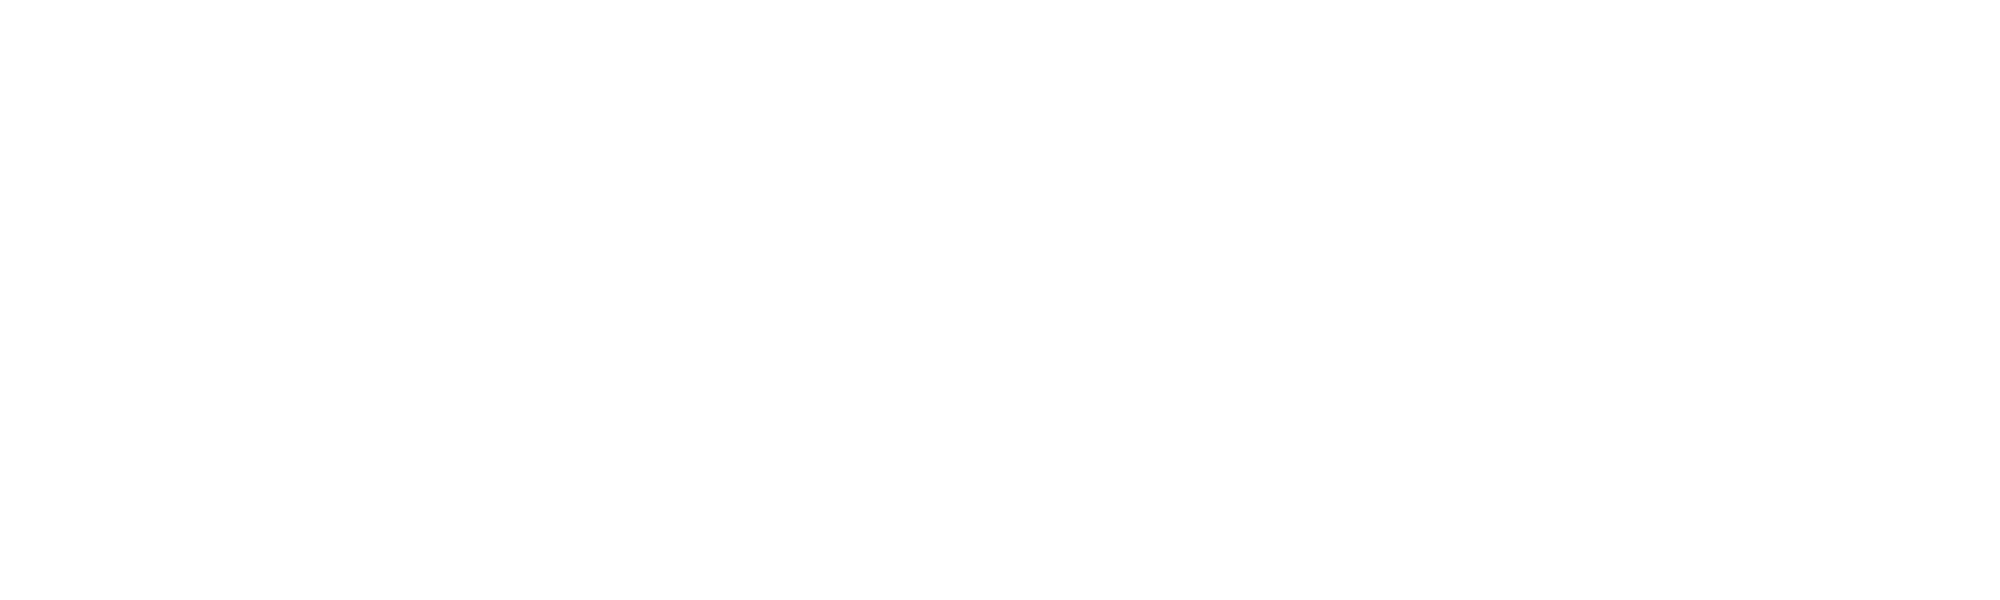

In [1]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib notebook

from shenfun import *

N = 24
T = Basis(N, 'F', dtype='D') # Using complex initial data
Tp = Basis(N, 'F', dtype='D', padding_factor=1.5)
x = T.mesh()
k = T.wavenumbers(scaled=True, eliminate_highest_freq=True)

# Choose papameters
Re = 5.0
We = 755.
theta = np.pi/2.
h0 = 0.000042
lmbda = 0.0098
alpha = 2*np.pi*h0/lmbda
B_1 = 8./15.*Re-2./3./np.tan(theta)
C_1 = 2./3.*alpha**2*We

# Arrays to hold the solution
eta_ = Array(T)
etap = Array(Tp)      # For the nonlinear part
eta_hat = Function(T)
eta_lin_hat = Function(T)
eta_lin = Array(T)

# Initialize wavenumber w0
w0 = 1
eta_hat[w0] = h0

# The integrator needs one function to compute the linear part, 
# and one term for the nonlinear.
def LinearRHS(self, **params):
    """Return linear operator for right hand side."""
    L = -2*1j*k - alpha*(-B_1*k**2 + C_1*k**4)
    return L

def NonlinearRHS(self, eta, eta_hat, rhs, **params):
    """Return nonlinear part of right hand side."""
    rhs.fill(0)
    etap[:] = Tp.backward(eta_hat, etap)
    rhs = Tp.forward(-2*etap**2, rhs)
    rhs *= 1j*k
    return rhs

def get_linear_solution(u_hat, t):
    """Return linear exact solution at time t."""
    u_hat[w0] = h0*np.exp(LinearRHS(None)[w0]*t)
    return u_hat.backward()

data = []
def update(self, eta, eta_hat, t, tstep, plot_step, fig, **par):
    """Function called at the end of each time step."""
    if tstep % plot_step == 0 and plot_step > 0:
        eta = eta_hat.backward(eta)
        eta_lin = get_linear_solution(eta_lin_hat, t)
        fig.add_subplot(121)
        fig.gca().plot(x, eta)
        fig.add_subplot(122)
        fig.gca().plot(x, eta-eta_lin)
        display.clear_output(wait=True)
        display.display(fig)
        data.append(eta_hat.copy())

# Specify time step size and end time. 
dt = 0.002
end_time = 2.
# Prepare figure for dynamic plotting
fig = plt.figure(1, figsize=(10, 3))
fig.add_subplot(121)
plt.title('$\eta$')
fig.add_subplot(122)
plt.title('nonlinear contribution')
par = {'plot_step': 100, 'fig': fig}
integrator = ETDRK4(T, L=LinearRHS, N=NonlinearRHS, update=update, **par)
integrator.setup(dt)
eta_hat = integrator.solve(eta_, eta_hat, dt, (0, end_time))
plt.close()
#plt.show()

Do postprocessing below if needed.

In [10]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()
p = figure(title='eta')
p.line(x, eta_.real)
p.circle(x, eta_.imag)
show(p)

Loading BokehJS ...